In [1]:
import os
import glob
import random
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nib
from scipy.ndimage import zoom

class FMRI3DDataset(Dataset):
    def __init__(self, root_dir, noise_level=0.1, exclude_subject="subuu", 
                 max_samples=1000, downsample_factor=1.0):
        """
        Args:
            root_dir (str): Directory with .nii.gz files.
            noise_level (float): Max fraction of image intensity for Gaussian noise.
            exclude_subject (str): Subject ID to exclude.
            max_samples (int): Cap the number of samples to prevent memory overload.
            downsample_factor (float): Factor to downsample volumes (e.g., 0.5 for half-res).
        """
        self.noise_level = noise_level
        self.downsample_factor = downsample_factor
        self.samples = []

        # Gather all relevant file paths
        all_paths = glob.glob(os.path.join(root_dir, '**/*.nii.gz'), recursive=True)
        self.volume_paths = [p for p in all_paths if exclude_subject not in p]
        random.shuffle(self.volume_paths)

        # Extract timepoints from 4D fMRI files
        for path in self.volume_paths:
            try:
                nii = nib.load(path)
                data = nii.get_fdata()
                if data.ndim == 4:
                    for t in range(data.shape[3]):
                        self.samples.append((path, t))
            except Exception as e:
                print(f"Error loading {path}: {e}")

        # Cap number of samples to avoid overloading RAM
        if len(self.samples) > max_samples:
            self.samples = self.samples[:max_samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, t = self.samples[idx]

        # Load the t-th volume
        volume = nib.load(path).get_fdata()[..., t]

        # Downsample if needed
        if self.downsample_factor < 1.0:
            volume = zoom(volume, zoom=self.downsample_factor)

        # Normalize to [0, 1]
        min_val, max_val = np.min(volume), np.max(volume)
        volume = (volume - min_val) / (max_val - min_val + 1e-8)

        # Add Gaussian noise per slice
        global_max = np.max(volume) 
        noisy_volume = np.zeros_like(volume)
        for z in range(volume.shape[2]):
            slice_ = volume[:, :, z]
            max_intensity = np.max(slice_)
            noise_std = max(1e-3, np.random.uniform(0.8 * self.noise_level, self.noise_level) * global_max)
            noise = np.random.normal(0, noise_std, slice_.shape)
            noisy_volume[:, :, z] = slice_ + noise

        # Convert to tensors with channel dimension
        x_clean = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)
        x_noisy = torch.tensor(noisy_volume, dtype=torch.float32).unsqueeze(0)

        # Clamp to [0, 1] after noise
        x_noisy = torch.clamp(x_noisy, 0.0, 1.0)


        return x_noisy, x_clean



In [1]:
import glob
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset


class FMRI3DDataset(Dataset):
    def __init__(self, root_dir, noise_std=0.1):
        """
        Args:
            root_dir (str): Directory where the fMRI .nii.gz files are located.
            noise_std (float): Max std. dev. of Gaussian noise added to the input.
        """
        self.volume_paths = glob.glob(os.path.join(root_dir, '**/*.nii.gz'), recursive=True)
        self.noise_std = noise_std
        self.samples = []  # list of (path, time_idx)

        for path in self.volume_paths:
            nii = nib.load(path)
            data = nii.get_fdata()
            if data.ndim == 4:
                for t in range(data.shape[3]):
                    self.samples.append((path, t))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, t = self.samples[idx]

        # Load the 3D volume at time index t
        volume = nib.load(path).get_fdata()[..., t]

        # Normalize to [0, 1]
        volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)

         # Add Gaussian noise per slice
        global_max = np.max(volume) 
        noisy_volume = np.zeros_like(volume)
        for z in range(volume.shape[2]):
            slice_ = volume[:, :, z]
            max_intensity = np.max(slice_)
            noise_std = np.random.uniform(0, self.noise_std) * max_intensity
            noise = np.random.normal(0, noise_std, slice_.shape)
            noisy_volume[:, :, z] = slice_ + noise

        # Convert to tensors with channel dimension
        x_clean = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)
        x_noisy = torch.tensor(noisy_volume, dtype=torch.float32).unsqueeze(0)

        # Clamp to [0, 1] after noise
        x_noisy = torch.clamp(x_noisy, 0.0, 1.0)


        return x_noisy, x_clean

 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet3DfMRI(nn.Module):
    def __init__(self, input_channels=1, conv_filt=32, kernel_size=5, activation="relu", pool_size=2):
        super(UNet3DfMRI, self).__init__()
        padding = kernel_size // 2
        act_fn = nn.ReLU() if activation == "relu" else nn.LeakyReLU(0.2)

        self.pool_size = pool_size
        self.total_down_factor = pool_size ** 4  # 4 pooling layers → factor 16

        # Encoder
        self.enc1 = self._block(input_channels, conv_filt, kernel_size, padding, act_fn)
        self.pool1 = nn.MaxPool3d(pool_size)

        self.enc2 = self._block(conv_filt, 2*conv_filt, kernel_size, padding, act_fn)
        self.pool2 = nn.MaxPool3d(pool_size)

        self.enc3 = self._block(2*conv_filt, 4*conv_filt, kernel_size, padding, act_fn)
        self.pool3 = nn.MaxPool3d(pool_size)

        self.enc4 = self._block(4*conv_filt, 8*conv_filt, kernel_size, padding, act_fn)
        self.pool4 = nn.MaxPool3d(pool_size)

        # Bottleneck
        self.bottleneck = self._block(8*conv_filt, 16*conv_filt, kernel_size, padding, act_fn)

        # Decoder
        self.up4 = nn.ConvTranspose3d(16*conv_filt, 8*conv_filt, kernel_size=2, stride=2)
        self.dec4 = self._block(16*conv_filt, 8*conv_filt, kernel_size, padding, act_fn)

        self.up3 = nn.ConvTranspose3d(8*conv_filt, 4*conv_filt, kernel_size=2, stride=2)
        self.dec3 = self._block(8*conv_filt, 4*conv_filt, kernel_size, padding, act_fn)

        self.up2 = nn.ConvTranspose3d(4*conv_filt, 2*conv_filt, kernel_size=2, stride=2)
        self.dec2 = self._block(4*conv_filt, 2*conv_filt, kernel_size, padding, act_fn)

        self.up1 = nn.ConvTranspose3d(2*conv_filt, conv_filt, kernel_size=2, stride=2)
        self.dec1 = self._block(2*conv_filt, conv_filt, kernel_size, padding, act_fn)

        self.output_conv = nn.Conv3d(conv_filt, 1, kernel_size=1)
        self.apply(self._initialize_weights)

    def _block(self, in_channels, out_channels, kernel_size, padding, act_fn):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm3d(out_channels),
            act_fn,
            nn.Conv3d(out_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm3d(out_channels),
            act_fn
        )

    def _initialize_weights(self, module):
        import torch.nn.init as init
        if isinstance(module, (nn.Conv3d, nn.ConvTranspose3d)):
            init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm3d):
            init.constant_(module.weight, 1)
            init.constant_(module.bias, 0)

    def pad_to_divisible(self, x):
        """
        Pad x with zeros so that its spatial dims are divisible by total_down_factor.
        Returns the padded tensor and the original shape for proper unpadding.
        """
        _, _, d, h, w = x.shape
        factor = self.total_down_factor

        pad_d = (factor - d % factor) % factor
        pad_h = (factor - h % factor) % factor
        pad_w = (factor - w % factor) % factor

        # Distribute padding as evenly as possible
        pad_d_front = pad_d // 2
        pad_d_back = pad_d - pad_d_front
        pad_h_top = pad_h // 2
        pad_h_bottom = pad_h - pad_h_top
        pad_w_left = pad_w // 2
        pad_w_right = pad_w - pad_w_left

        padding = (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom, pad_d_front, pad_d_back)
        x_padded = F.pad(x, padding)

        # Store original shape for unpadding
        original_shape = (d, h, w)
        return x_padded, (original_shape, padding)

    def remove_padding(self, x, padding_info):
        """
        Remove padding from the tensor x using the original shape.
        """
        original_shape, padding = padding_info
        orig_d, orig_h, orig_w = original_shape
        
        # Simply crop to original dimensions from the center
        _, _, curr_d, curr_h, curr_w = x.shape
        
        # Calculate start indices (should be the padding we added)
        start_d = (curr_d - orig_d) // 2
        start_h = (curr_h - orig_h) // 2
        start_w = (curr_w - orig_w) // 2
        
        return x[:, :, 
                start_d:start_d + orig_d,
                start_h:start_h + orig_h, 
                start_w:start_w + orig_w]

    def forward(self, x):
        # Store original shape and pad
        original_shape = x.shape[2:]  # (D, H, W)
        x, padding_info = self.pad_to_divisible(x)
        
        # Debug prints (remove these once working)
        

        # Encoder
        conv1 = self.enc1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.enc2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.enc3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.enc4(pool3)
        pool4 = self.pool4(conv4)

        # Bottleneck
        bottleneck = self.bottleneck(pool4)

        # Decoder
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([conv4, up4], dim=1))

        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([conv3, up3], dim=1))

        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([conv2, up2], dim=1))

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([conv1, up1], dim=1))

        out = self.output_conv(dec1)
        

        # Remove padding to get back to original shape
        out = self.remove_padding(out, padding_info)


        return out

In [3]:



import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

from torchvision.utils import make_grid
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


#from fMRI_Denoising.unet.dataset import FMRI3DDataset
#from fMRI_Denoising.unet.model import UNet3DfMRI
#from fMRI_Denoising.unet.evaluate import evaluate_model

In [4]:


def fft_loss(pred, target):
    pred_fft = torch.fft.fftn(pred, dim=(-3, -2, -1))
    target_fft = torch.fft.fftn(target, dim=(-3, -2, -1))
    return torch.mean(torch.abs(pred_fft - target_fft))

def train_model(model: nn.Module, dataloader: DataLoader, device, epochs: int = 5, lr: float = 1e-4, writer: SummaryWriter = None, resume_from_epoch: int = 0):
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    fft_loss_weight = 0.05
    global_step = 0

    for epoch in range(resume_from_epoch, epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch_idx, (x, y) in enumerate(progress_bar):
            x, y = x.to(device), y.to(device)
            
            
            
            pred = model(x)
            
            

            # Check for shape mismatches - this shouldn't happen with proper padding
            if pred.shape != y.shape:
                print(f"Warning: Shape mismatch! pred: {pred.shape}, target: {y.shape}")
                # Instead of cropping, investigate why shapes don't match
                min_shape = [min(pred.shape[i], y.shape[i]) for i in range(len(pred.shape))]
                pred = pred[:, :, :min_shape[2], :min_shape[3], :min_shape[4]]
                y = y[:, :, :min_shape[2], :min_shape[3], :min_shape[4]]

            # Standard MSE loss
            mse_loss = loss_fn(pred, y)
            
            # Add FFT frequency loss
            fft_loss_val = fft_loss(pred, y)
            loss = mse_loss + fft_loss_weight * fft_loss_val

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

            # Logging code remains the same...
            if writer and (global_step % 10 == 0):
                writer.add_scalar("Loss/train", loss.item(), global_step)
                writer.add_scalar("Loss/mse", mse_loss.item(), global_step)
                writer.add_scalar("Loss/fft", fft_loss_val.item(), global_step)

            if writer and (batch_idx % (len(dataloader) // 10 + 1) == 0):
                with torch.no_grad():
                    x_slice = x[0, 0, :, :, x.shape[4] // 2].cpu().unsqueeze(0)
                    y_slice = y[0, 0, :, :, y.shape[4] // 2].cpu().unsqueeze(0)
                    pred_slice = pred[0, 0, :, :, pred.shape[4] // 2].cpu().unsqueeze(0)

                    grid = make_grid(torch.stack([x_slice, y_slice, pred_slice]), nrow=3, normalize=False)
                    writer.add_image(f"Epoch_{epoch+1}/Input_GT_Pred", grid, global_step)


            global_step += 1

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}")

        if writer:
            writer.add_scalar("Loss/epoch_avg", avg_loss, epoch + 1)

        torch.save(model.state_dict(), f"./runs/model_weights_epoch{epoch + 1}.pth")


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from scipy import signal
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def compute_frequency_spectrum(volume):
    """
    Compute 3D frequency spectrum of a volume.
    
    Args:
        volume: torch.Tensor of shape (B, C, D, H, W) or (D, H, W)
    
    Returns:
        magnitude_spectrum: Magnitude of the 3D FFT
        phase_spectrum: Phase of the 3D FFT
        power_spectrum: Power spectrum (magnitude squared)
    """
    if volume.dim() == 5:  # (B, C, D, H, W)
        volume = volume.squeeze()  # Remove batch and channel dims if present
    elif volume.dim() == 4:  # (C, D, H, W)
        volume = volume.squeeze(0)  # Remove channel dim
    
    # Compute 3D FFT
    fft_volume = torch.fft.fftn(volume, dim=(-3, -2, -1))
    
    # Get magnitude and phase
    magnitude_spectrum = torch.abs(fft_volume)
    phase_spectrum = torch.angle(fft_volume)
    power_spectrum = magnitude_spectrum ** 2
    
    return magnitude_spectrum, phase_spectrum, power_spectrum


def compute_radial_profile(spectrum):
    """
    Compute radially averaged power spectrum.
    
    Args:
        spectrum: 3D power spectrum tensor
    
    Returns:
        frequencies: Array of spatial frequencies
        radial_profile: Radially averaged power
    """
    spectrum_np = spectrum.cpu().numpy()
    d, h, w = spectrum_np.shape
    
    # Create coordinate grids
    z_coords = np.arange(d) - d // 2
    y_coords = np.arange(h) - h // 2
    x_coords = np.arange(w) - w // 2
    
    Z, Y, X = np.meshgrid(z_coords, y_coords, x_coords, indexing='ij')
    
    # Compute radial distance
    R = np.sqrt(Z**2 + Y**2 + X**2)
    
    # Shift zero frequency to center
    spectrum_shifted = np.fft.fftshift(spectrum_np)
    
    # Compute radial profile
    max_radius = int(np.min([d, h, w]) // 2)
    radial_profile = np.zeros(max_radius)
    frequencies = np.arange(max_radius)
    
    for r in range(max_radius):
        mask = (R >= r) & (R < r + 1)
        if np.sum(mask) > 0:
            radial_profile[r] = np.mean(spectrum_shifted[mask])
    
    return frequencies, radial_profile




In [6]:
def analyze_frequency_content(ground_truth, prediction, writer, global_step, prefix=""):
    """
    Comprehensive frequency analysis between ground truth and prediction.
    
    Args:
        ground_truth: torch.Tensor of shape (B, C, D, H, W)
        prediction: torch.Tensor of shape (B, C, D, H, W)
        writer: TensorBoard SummaryWriter
        global_step: Current training step
        prefix: Prefix for TensorBoard tags
    """
    batch_size = ground_truth.shape[0]
    
    # Process each sample in the batch
    for batch_idx in range(min(batch_size, 2)):  # Limit to first 2 samples to avoid overwhelming TB
        gt_sample = ground_truth[batch_idx]
        pred_sample = prediction[batch_idx]
        
        # Compute frequency spectra
        gt_mag, gt_phase, gt_power = compute_frequency_spectrum(gt_sample)
        pred_mag, pred_phase, pred_power = compute_frequency_spectrum(pred_sample)
        
        # 1. Log magnitude spectra statistics
        writer.add_scalar(f"{prefix}Frequency/GT_Magnitude_Mean_Sample_{batch_idx}", 
                         torch.mean(gt_mag).item(), global_step)
        writer.add_scalar(f"{prefix}Frequency/Pred_Magnitude_Mean_Sample_{batch_idx}", 
                         torch.mean(pred_mag).item(), global_step)
        
        writer.add_scalar(f"{prefix}Frequency/GT_Magnitude_Std_Sample_{batch_idx}", 
                         torch.std(gt_mag).item(), global_step)
        writer.add_scalar(f"{prefix}Frequency/Pred_Magnitude_Std_Sample_{batch_idx}", 
                         torch.std(pred_mag).item(), global_step)
        
        # 2. Log power spectrum statistics
        writer.add_scalar(f"{prefix}Frequency/GT_Power_Mean_Sample_{batch_idx}", 
                         torch.mean(gt_power).item(), global_step)
        writer.add_scalar(f"{prefix}Frequency/Pred_Power_Mean_Sample_{batch_idx}", 
                         torch.mean(pred_power).item(), global_step)
        
        # 3. Frequency domain loss metrics
        magnitude_diff = torch.mean(torch.abs(gt_mag - pred_mag))
        phase_diff = torch.mean(torch.abs(gt_phase - pred_phase))
        power_diff = torch.mean(torch.abs(gt_power - pred_power))
        
        writer.add_scalar(f"{prefix}Frequency/Magnitude_L1_Loss_Sample_{batch_idx}", 
                         magnitude_diff.item(), global_step)
        writer.add_scalar(f"{prefix}Frequency/Phase_L1_Loss_Sample_{batch_idx}", 
                         phase_diff.item(), global_step)
        writer.add_scalar(f"{prefix}Frequency/Power_L1_Loss_Sample_{batch_idx}", 
                         power_diff.item(), global_step)
        
        # 4. Compute and log radial profiles
        gt_freqs, gt_radial = compute_radial_profile(gt_power)
        pred_freqs, pred_radial = compute_radial_profile(pred_power)
        
        # Create radial profile comparison plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.semilogy(gt_freqs, gt_radial, 'b-', label='Ground Truth', linewidth=2)
        ax.semilogy(pred_freqs, pred_radial, 'r--', label='Prediction', linewidth=2)
        ax.set_xlabel('Spatial Frequency')
        ax.set_ylabel('Power (log scale)')
        ax.set_title(f'Radial Power Spectrum - Sample {batch_idx}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        writer.add_figure(f"{prefix}Frequency/Radial_Power_Spectrum_Sample_{batch_idx}", 
                         fig, global_step)
        plt.close(fig)
        
        # 5. Log frequency band energies
        # Low frequencies (0-25% of max freq)
        # Mid frequencies (25-75% of max freq)  
        # High frequencies (75-100% of max freq)
        max_freq = len(gt_freqs)
        low_end = max_freq // 4
        high_start = 3 * max_freq // 4
        
        gt_low_energy = np.sum(gt_radial[:low_end])
        gt_mid_energy = np.sum(gt_radial[low_end:high_start])
        gt_high_energy = np.sum(gt_radial[high_start:])
        
        pred_low_energy = np.sum(pred_radial[:low_end])
        pred_mid_energy = np.sum(pred_radial[low_end:high_start])
        pred_high_energy = np.sum(pred_radial[high_start:])
        
        writer.add_scalar(f"{prefix}Frequency/GT_Low_Freq_Energy_Sample_{batch_idx}", 
                         gt_low_energy, global_step)
        writer.add_scalar(f"{prefix}Frequency/GT_Mid_Freq_Energy_Sample_{batch_idx}", 
                         gt_mid_energy, global_step)
        writer.add_scalar(f"{prefix}Frequency/GT_High_Freq_Energy_Sample_{batch_idx}", 
                         gt_high_energy, global_step)
        
        writer.add_scalar(f"{prefix}Frequency/Pred_Low_Freq_Energy_Sample_{batch_idx}", 
                         pred_low_energy, global_step)
        writer.add_scalar(f"{prefix}Frequency/Pred_Mid_Freq_Energy_Sample_{batch_idx}", 
                         pred_mid_energy, global_step)
        writer.add_scalar(f"{prefix}Frequency/Pred_High_Freq_Energy_Sample_{batch_idx}", 
                         pred_high_energy, global_step)
        
        # 6. Frequency band error ratios
        if gt_low_energy > 0:
            low_freq_error = abs(pred_low_energy - gt_low_energy) / gt_low_energy
            writer.add_scalar(f"{prefix}Frequency/Low_Freq_Relative_Error_Sample_{batch_idx}", 
                             low_freq_error, global_step)
        
        if gt_mid_energy > 0:
            mid_freq_error = abs(pred_mid_energy - gt_mid_energy) / gt_mid_energy
            writer.add_scalar(f"{prefix}Frequency/Mid_Freq_Relative_Error_Sample_{batch_idx}", 
                             mid_freq_error, global_step)
        
        if gt_high_energy > 0:
            high_freq_error = abs(pred_high_energy - gt_high_energy) / gt_high_energy
            writer.add_scalar(f"{prefix}Frequency/High_Freq_Relative_Error_Sample_{batch_idx}", 
                             high_freq_error, global_step)


def create_frequency_visualizations(ground_truth, prediction, writer, global_step, prefix=""):
    """
    Create detailed frequency domain visualizations.
    
    Args:
        ground_truth: torch.Tensor of shape (B, C, D, H, W)
        prediction: torch.Tensor of shape (B, C, D, H, W)
        writer: TensorBoard SummaryWriter
        global_step: Current training step
        prefix: Prefix for TensorBoard tags
    """
    # Take middle slice for 2D visualization
    gt_slice = ground_truth[0, 0, :, :, ground_truth.shape[4] // 2].cpu().numpy()
    pred_slice = prediction[0, 0, :, :, prediction.shape[4] // 2].cpu().numpy()
    
    # Compute 2D FFT for visualization
    gt_fft_2d = np.fft.fft2(gt_slice)
    pred_fft_2d = np.fft.fft2(pred_slice)
    
    # Magnitude spectra (log scale for better visualization)
    gt_mag_2d = np.log(np.abs(np.fft.fftshift(gt_fft_2d)) + 1e-8)
    pred_mag_2d = np.log(np.abs(np.fft.fftshift(pred_fft_2d)) + 1e-8)
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original images
    im1 = axes[0, 0].imshow(gt_slice, cmap='gray')
    axes[0, 0].set_title('Ground Truth')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
    
    im2 = axes[0, 1].imshow(pred_slice, cmap='gray')
    axes[0, 1].set_title('Prediction')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    
    # Difference
    diff = np.abs(gt_slice - pred_slice)
    im3 = axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('Absolute Difference')
    axes[0, 2].axis('off')
    plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)
    
    # Frequency domain
    im4 = axes[1, 0].imshow(gt_mag_2d, cmap='viridis')
    axes[1, 0].set_title('GT Magnitude Spectrum (log)')
    axes[1, 0].axis('off')
    plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)
    
    im5 = axes[1, 1].imshow(pred_mag_2d, cmap='viridis')
    axes[1, 1].set_title('Pred Magnitude Spectrum (log)')
    axes[1, 1].axis('off')
    plt.colorbar(im5, ax=axes[1, 1], fraction=0.046)
    
    # Frequency domain difference
    freq_diff = np.abs(gt_mag_2d - pred_mag_2d)
    im6 = axes[1, 2].imshow(freq_diff, cmap='plasma')
    axes[1, 2].set_title('Frequency Domain Difference')
    axes[1, 2].axis('off')
    plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)
    
    plt.tight_layout()
    writer.add_figure(f"{prefix}Frequency/Detailed_Comparison", fig, global_step)
    plt.close(fig)

In [7]:
def create_frequency_visualizations(noisy_input, ground_truth, prediction, writer, global_step, prefix=""):
    """
    Visualize spatial and frequency domain slices of noisy input, ground truth, and prediction.
    
    Args:
        noisy_input: torch.Tensor of shape (B, C, D, H, W)
        ground_truth: torch.Tensor of shape (B, C, D, H, W)
        prediction: torch.Tensor of shape (B, C, D, H, W)
        writer: TensorBoard SummaryWriter
        global_step: Current training step
        prefix: Prefix for TensorBoard tags
    """
    # Extract central slice in width axis (W)
    slice_idx = ground_truth.shape[4] // 2
    noisy_slice = noisy_input[0, 0, :, :, slice_idx].cpu().numpy()
    gt_slice = ground_truth[0, 0, :, :, slice_idx].cpu().numpy()
    pred_slice = prediction[0, 0, :, :, slice_idx].cpu().numpy()

    # FFT computations (2D)
    fft_noisy = np.fft.fft2(noisy_slice)
    fft_gt = np.fft.fft2(gt_slice)
    fft_pred = np.fft.fft2(pred_slice)

    # Magnitudes
    mag_noisy = np.log(np.abs(np.fft.fftshift(fft_noisy)) + 1e-8)
    mag_gt = np.log(np.abs(np.fft.fftshift(fft_gt)) + 1e-8)
    mag_pred = np.log(np.abs(np.fft.fftshift(fft_pred)) + 1e-8)

    # Plotting
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    # Spatial domain
    im0 = axes[0, 0].imshow(noisy_slice, cmap='gray')
    axes[0, 0].set_title("Noisy Input")
    axes[0, 0].axis("off")
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

    im1 = axes[0, 1].imshow(gt_slice, cmap='gray')
    axes[0, 1].set_title("Ground Truth")
    axes[0, 1].axis("off")
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

    im2 = axes[0, 2].imshow(pred_slice, cmap='gray')
    axes[0, 2].set_title("Prediction")
    axes[0, 2].axis("off")
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

    # Difference images
    im3 = axes[1, 0].imshow(np.abs(noisy_slice - gt_slice), cmap='hot')
    axes[1, 0].set_title("Noisy vs GT Diff")
    axes[1, 0].axis("off")
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046)

    im4 = axes[1, 1].imshow(np.abs(gt_slice - pred_slice), cmap='hot')
    axes[1, 1].set_title("GT vs Pred Diff")
    axes[1, 1].axis("off")
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046)

    im5 = axes[1, 2].imshow(np.abs(noisy_slice - pred_slice), cmap='hot')
    axes[1, 2].set_title("Noisy vs Pred Diff")
    axes[1, 2].axis("off")
    plt.colorbar(im5, ax=axes[1, 2], fraction=0.046)

    # Frequency domain
    im6 = axes[2, 0].imshow(mag_noisy, cmap='viridis')
    axes[2, 0].set_title("Noisy FFT Magnitude")
    axes[2, 0].axis("off")
    plt.colorbar(im6, ax=axes[2, 0], fraction=0.046)

    im7 = axes[2, 1].imshow(mag_gt, cmap='viridis')
    axes[2, 1].set_title("GT FFT Magnitude")
    axes[2, 1].axis("off")
    plt.colorbar(im7, ax=axes[2, 1], fraction=0.046)

    im8 = axes[2, 2].imshow(mag_pred, cmap='viridis')
    axes[2, 2].set_title("Pred FFT Magnitude")
    axes[2, 2].axis("off")
    plt.colorbar(im8, ax=axes[2, 2], fraction=0.046)

    plt.tight_layout()
    writer.add_figure(f"{prefix}Frequency/Full_Comparison", fig, global_step)
    plt.close(fig)


In [8]:



# Updated training function with frequency analysis
def train_model_with_frequency_analysis(model, dataloader, device, epochs=5, lr=1e-4, writer=None, resume_from_epoch=0):
    """
    Training function with integrated frequency analysis.
    """
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    
    fft_loss_weight = 0.05
    global_step = 0

    for epoch in range(resume_from_epoch, epochs):
        total_loss = 0
        
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_idx, (x, y) in enumerate(progress_bar):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            # Handle shape mismatch if it still occurs
            if pred.shape != y.shape:
                min_shape = [min(pred.shape[i], y.shape[i]) for i in range(len(pred.shape))]
                pred = pred[:, :, :min_shape[2], :min_shape[3], :min_shape[4]]
                y = y[:, :, :min_shape[2], :min_shape[3], :min_shape[4]]
            
            # Standard loss
            mse_loss = loss_fn(pred, y)
            
            # FFT loss
            pred_fft = torch.fft.fftn(pred, dim=(-3, -2, -1))
            target_fft = torch.fft.fftn(y, dim=(-3, -2, -1))
            fft_loss_val = torch.mean(torch.abs(pred_fft - target_fft))
            
            loss = mse_loss + fft_loss_weight * fft_loss_val
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            # Frequency analysis every 20 steps
            if writer and (global_step % 20 == 0):
                with torch.no_grad():
                    analyze_frequency_content(y, pred, writer, global_step, "Train/")
                    
                    # Detailed visualizations every 100 steps
                    if global_step % 100 == 0:
                        create_frequency_visualizations(x, y, pred, writer, global_step, "Train/")
            
            # Regular logging
            if writer and (global_step % 10 == 0):
                writer.add_scalar("Loss/train", loss.item(), global_step)
                writer.add_scalar("Loss/mse", mse_loss.item(), global_step)
                writer.add_scalar("Loss/fft", fft_loss_val.item(), global_step)
            
            global_step += 1
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}")
        
        if writer:
            writer.add_scalar("Loss/epoch_avg", avg_loss, epoch + 1)
        
        # Save model
        torch.save(model.state_dict(), f"./runs/model_weights_epoch{epoch + 1}.pth")




In [9]:
if __name__ == "__main__":
    root_dir = "/home/qureshi/Documents/fmri/fMRI"
    batch_size = 4
    num_epochs = 6
    learning_rate = 1e-4
    resume_epoch = 5
    writer = SummaryWriter()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load full dataset
    full_dataset = FMRI3DDataset(root_dir)

    # Train/test split (optional, only useful if evaluation is separate)
    train_dataset = full_dataset

    # Dataloader for training set only
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, prefetch_factor=8
    )

    # Initialize and optionally load pretrained weights
    model = UNet3DfMRI().to(device)

    if resume_epoch > 0:
        weight_path = f"./runs/model_weights_epoch{resume_epoch}.pth"
        model.load_state_dict(torch.load(weight_path))
        print(f"Resuming training from epoch {resume_epoch} using {weight_path}")
    else:
        print("Starting training from scratch...")

    # Train
    train_model_with_frequency_analysis(
        model,
        train_loader,
        device,
        epochs=num_epochs,
        lr=learning_rate,
        writer=writer,
        resume_from_epoch=resume_epoch
    )

    print("Training complete.")
    writer.close()


Resuming training from epoch 5 using ./runs/model_weights_epoch5.pth


Epoch 6/6, Avg Loss: 0.1241
Training complete.


In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)

    mse_list = []
    psnr_list = []
    ssim_list = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for i, (x, y) in enumerate(progress_bar):
            x, y = x.to(device), y.to(device)
            pred = model(x)

            # Convert tensors to numpy (assuming shape: [1, 1, D, H, W])
            y_np = y.squeeze().cpu().numpy()
            pred_np = pred.squeeze().cpu().numpy()

            # Metrics per 3D volume
            mse_score = np.mean((y_np - pred_np) ** 2)
            psnr_score = psnr(y_np, pred_np, data_range=1.0)
            ssim_score = ssim(y_np, pred_np, data_range=1.0)

            mse_list.append(mse_score)
            psnr_list.append(psnr_score)
            ssim_list.append(ssim_score)



    print(f"Evaluation Results:")
    print(f"  MSE  : {np.mean(mse_list):.6f}")
    print(f"  PSNR : {np.mean(psnr_list):.2f} dB")
    print(f"  SSIM : {np.mean(ssim_list):.4f}")


if __name__ == "__main__":
    import os

    root_dir = "/home/qureshi/Documents/fmri/fMRI/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = FMRI3DDataset(root_dir)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    model = UNet3DfMRI()
    model.load_state_dict(torch.load("runs/model_weights_epoch6.pth", map_location=device))

    print("Evaluating model...")
    evaluate_model(model, dataloader, device)

AttributeError: 'function' object has no attribute 'glob'

In [27]:

dataset = FMRI3DDataset(root_dir='/home/qureshi/Documents/fmri/fMRI')

# Pick the first sample (noisy input and clean ground truth)
x_noisy, x_clean = dataset[0]

# Save tensors as .pt files
torch.save(x_noisy, 'sample_input.pt')    # shape: [1, X, Y, Z]
torch.save(x_clean, 'ground_truth.pt')    # shape: [1, X, Y, Z]

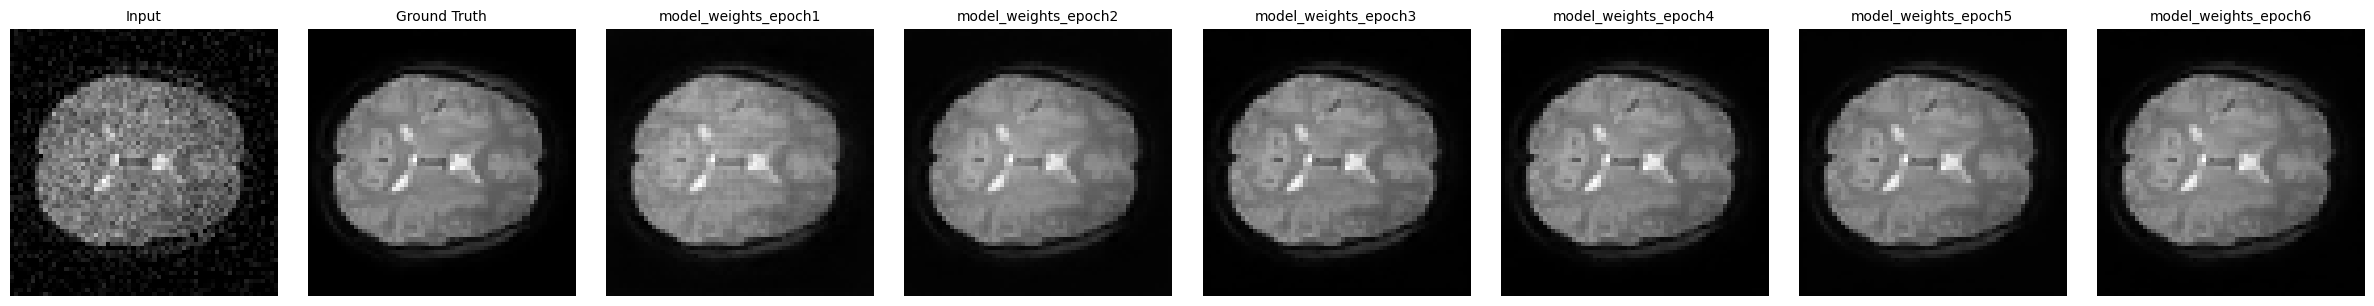

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Replace this with your actual model class

# --- CONFIGURATION ---
checkpoint_dir = './runs'
sample_path = './sample_input.pt'
ground_truth_path = './ground_truth.pt'  # Add path for ground truth
slice_axis = 2      # 0=X (sagittal), 1=Y (coronal), 2=Z (axial)
slice_index = 20    # Middle slice
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- LOAD INPUT VOLUME ---
input_vol = torch.load(sample_path).to(device)  # shape: [C, X, Y, Z]
input_vol = input_vol.unsqueeze(0)              # shape: [1, C, X, Y, Z]

# --- LOAD GROUND TRUTH VOLUME ---
gt_vol = torch.load(ground_truth_path).to(device)  # shape: [C, X, Y, Z]
gt_vol = gt_vol.unsqueeze(0)                        # shape: [1, C, X, Y, Z]

# For visualization: get original input slice
input_np = input_vol.squeeze().cpu().numpy()  # shape: [C, X, Y, Z] or [X,Y,Z] if C=1
if input_np.ndim == 4:  # if multiple channels, take first channel for visualization
    input_np = input_np[0]

if slice_axis == 0:
    slice_input = input_np[slice_index, :, :]
elif slice_axis == 1:
    slice_input = input_np[:, slice_index, :]
else:
    slice_input = input_np[:, :, slice_index]

# Normalize input slice
slice_input -= np.min(slice_input)
slice_input /= np.max(slice_input)

# For visualization: get ground truth slice
gt_np = gt_vol.squeeze().cpu().numpy()
if gt_np.ndim == 4:
    gt_np = gt_np[0]

if slice_axis == 0:
    slice_gt = gt_np[slice_index, :, :]
elif slice_axis == 1:
    slice_gt = gt_np[:, slice_index, :]
else:
    slice_gt = gt_np[:, :, slice_index]

# Normalize ground truth slice
slice_gt -= np.min(slice_gt)
slice_gt /= np.max(slice_gt)

# --- LOAD CHECKPOINTS AND MODEL OUTPUTS ---
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')])
outputs_by_epoch = [('Input', slice_input), ('Ground Truth', slice_gt)]

for ckpt in checkpoints:
    model = UNet3DfMRI().to(device)
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, ckpt)))
    model.eval()

    with torch.no_grad():
        output = model(input_vol).squeeze().cpu().numpy()  # shape: [X, Y, Z]

    # Get corresponding slice
    if slice_axis == 0:
        slice_img = output[slice_index, :, :]
    elif slice_axis == 1:
        slice_img = output[:, slice_index, :]
    else:
        slice_img = output[:, :, slice_index]

    # Normalize output slice
    slice_img -= np.min(slice_img)
    slice_img /= np.max(slice_img)

    outputs_by_epoch.append((ckpt.replace('.pth', ''), slice_img))

# --- PLOTTING ---
fig, axes = plt.subplots(1, len(outputs_by_epoch), figsize=(3 * len(outputs_by_epoch), 3))

for i, (label, img) in enumerate(outputs_by_epoch):
    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(label, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


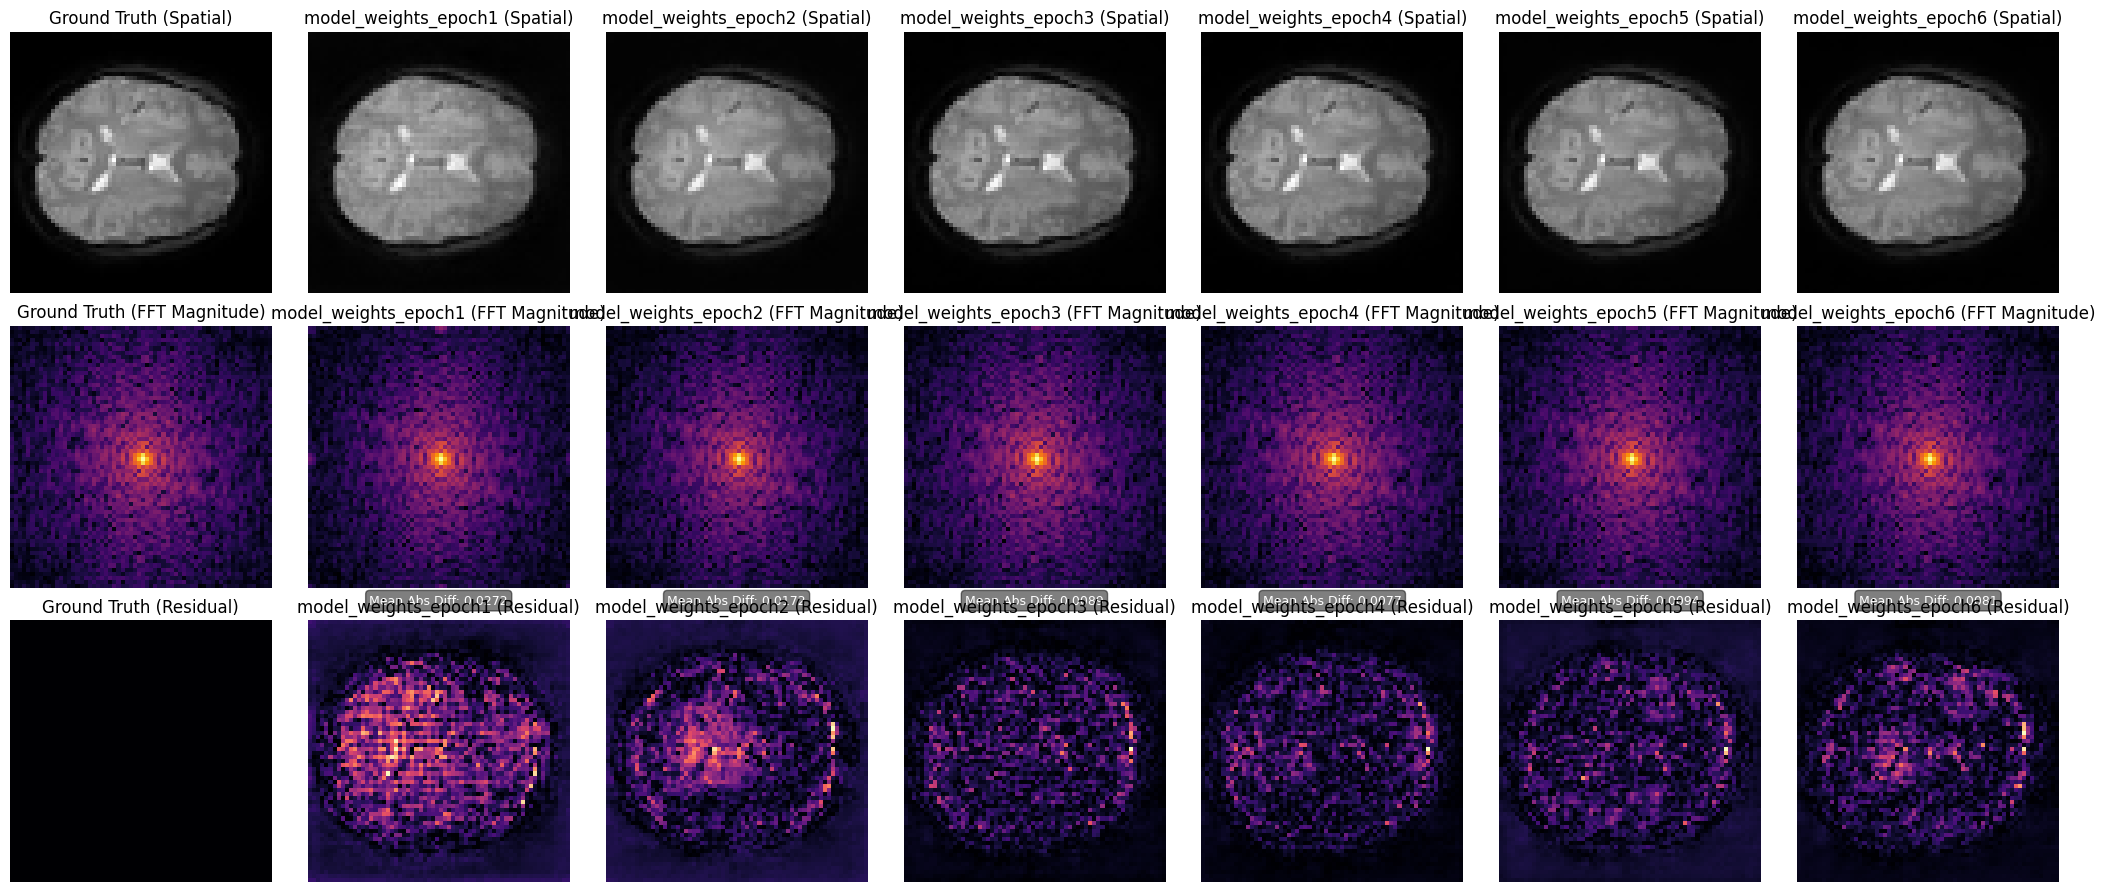

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os



# --- CONFIGURATION ---
checkpoint_dir = './runs'
sample_path = './sample_input.pt'
ground_truth_path = './ground_truth.pt'
slice_axis = 2      # 0=X (sagittal), 1=Y (coronal), 2=Z (axial)
slice_index = 20    # Slice index
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_slice(volume_np, axis, index):
    if axis == 0:
        return volume_np[index, :, :]
    elif axis == 1:
        return volume_np[:, index, :]
    else:
        return volume_np[:, :, index]

def normalize_img(img):
    img = img - np.min(img)
    max_val = np.max(img)
    if max_val > 0:
        img = img / max_val
    return img

def compute_fft_magnitude(img_2d):
    fft2 = np.fft.fft2(img_2d)
    fft2_shift = np.fft.fftshift(fft2)
    magnitude = np.log1p(np.abs(fft2_shift))
    return normalize_img(magnitude)

# --- LOAD VOLUMES ---
input_vol = torch.load(sample_path).to(device).unsqueeze(0)  # [1,C,X,Y,Z]
gt_vol = torch.load(ground_truth_path).to(device).unsqueeze(0)  # [1,C,X,Y,Z]

input_np = input_vol.squeeze().cpu().numpy()
gt_np = gt_vol.squeeze().cpu().numpy()

if input_np.ndim == 4:
    input_np = input_np[0]
if gt_np.ndim == 4:
    gt_np = gt_np[0]

# Get ground truth slice and normalize
slice_gt = normalize_img(get_slice(gt_np, slice_axis, slice_index))
slice_gt_fft = compute_fft_magnitude(slice_gt)

# --- LOAD CHECKPOINTS AND GET OUTPUTS ---
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')])

# Store tuples: (label, spatial_img, fft_img, residual_img, residual_value)
outputs_by_epoch = [('Ground Truth', slice_gt, slice_gt_fft, np.zeros_like(slice_gt), 0.0)]  # residual zero for GT

for ckpt in checkpoints:
    model = UNet3DfMRI().to(device)
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, ckpt)))
    model.eval()

    with torch.no_grad():
        output = model(input_vol).squeeze().cpu().numpy()

    slice_output = normalize_img(get_slice(output, slice_axis, slice_index))
    slice_output_fft = compute_fft_magnitude(slice_output)

    # Calculate residual difference (absolute)
    residual = np.abs(slice_output - slice_gt)
    residual_norm = normalize_img(residual)

    # Calculate mean absolute difference (scalar)
    residual_value = residual.mean()

    outputs_by_epoch.append((ckpt.replace('.pth', ''), slice_output, slice_output_fft, residual_norm, residual_value))

# --- PLOTTING ---
n = len(outputs_by_epoch)
fig, axes = plt.subplots(3, n, figsize=(3 * n, 9))

for i, (label, img, fft_img, residual_img, residual_val) in enumerate(outputs_by_epoch):
    # Spatial slice
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"{label} (Spatial)")
    axes[0, i].axis('off')

    # Frequency magnitude
    axes[1, i].imshow(fft_img, cmap='inferno')
    axes[1, i].set_title(f"{label} (FFT Magnitude)")
    axes[1, i].axis('off')

    # Residual difference
    axes[2, i].imshow(residual_img, cmap='magma')
    axes[2, i].set_title(f"{label} (Residual)")
    axes[2, i].axis('off')

    # Add text annotation of residual value on residual plot (skip for ground truth)
    if label != 'Ground Truth':
        axes[2, i].text(
            0.5, 1.05,  # x, y coordinates relative to axes (in axes coords)
            f"Mean Abs Diff: {residual_val:.4f}",
            color='white',
            fontsize=9,
            ha='center',
            va='bottom',
            transform=axes[2, i].transAxes,
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3')
        )

plt.tight_layout()
plt.show()



